<a href="https://colab.research.google.com/github/Benjamin-morel/TensorFlow/blob/main/11_%5BPINN%5D_heat_diffusion_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---


# **Machine Learning Model: physics-informed neural network and thermal diffusion**

| | |
|------|------|
| Filename | 11_[PINN]_heat_diffusion_equation.ipynb |
| Author(s) | Benjamin Morel (benjaminmorel27@gmail.com) |
| Date | March 01, 2025 |
| Aim(s) | Build and train a PINN model for solving a thermal diffusion problem |
| Dataset(s) | - |
| Version | Python 3.10.12 - TensorFlow 2.17.1 |


<br> **!!Read before running!!** <br>
1. Fill in the inputs
2. GPU execution is recommended
3. Run all and read comments

---

#### **Motivation**

---

## **0. Input section**

In [1]:
T_coffee = 100 # coffee temperature [°C]
T_room = 19 # environement temperature [°C]
t_cool = 15 # cooling time [min]

---

## **1. Python librairies & display utilities**

In [2]:
# @title 1.1. Python librairies [RUN ME]

"""math"""
import numpy as np # linear algebra
from functools import partial  # create a new function with pre-filled arguments

"""ML models"""
import tensorflow as tf # framework for ML/DL model
from tensorflow import keras # API used to build model in tensorflow
from keras import optimizers # optimization algorithms

"""display"""
import matplotlib.pyplot as plt # graphing package

"""performances"""
from time import time # timer
start = time()

DEVICE = tf.config.list_physical_devices(device_type=None)[-1][-1] # CPU or GPU

In [3]:
# @title 1.2. Import Github files [RUN ME]

"""clone the Github repertory TensorFlow and import files (see section 3.3)"""


'clone the Github repertory TensorFlow and import files (see section 3.3)'

In [4]:
# @title 1.3. Figure plots [RUN ME]

"""plot the temperature evolution according to the time (see section 2.1)"""
def plot_evolution(t, T, t_data, T_data):
    plt.plot(t, T) # temperature computed with physics laws
    plt.plot(t_data, T_data, 'o') # temperature measured
    plt.xlabel('Time [s]'), plt.ylabel('Temperature [°C]'), plt.legend(['Equation', 'Data'])

def plot_predictions(model, t, T, t_data, T_data):
    predictions = model.predict(t)
    plot_evolution(t, T, t_data, T_data)
    plt.plot(t, predictions, alpha=0.8)
    plt.xlabel('Time [s]'), plt.ylabel('Temperature [°C]'), plt.legend(['Equation', 'Data', 'PINN'])

---


## **2. Data generation and boundaries confiditions**

In [5]:
"""convert a NumPy array into a TensorFlow tensor"""
def np_to_tf(x):
    tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    tensor = tf.reshape(tensor, (len(x), -1)) # vertical tensor

    with tf.device('/' + DEVICE + ':0'):
        return tensor

In [6]:
"""give the temperature of the coffee at any time"""
def physics_law(time, Tenv, T0, CR):
    T = Tenv + (T0 - Tenv) * np.exp(-CR * time) # solution of the equation
    return T # in °C

In [7]:
np.random.seed(10)

cooling_rate = 0.005 # cooling rate

t = np.linspace(0, 60*t_cool, 60*t_cool)

T = physics_law(t, T_room, T_coffee, cooling_rate)

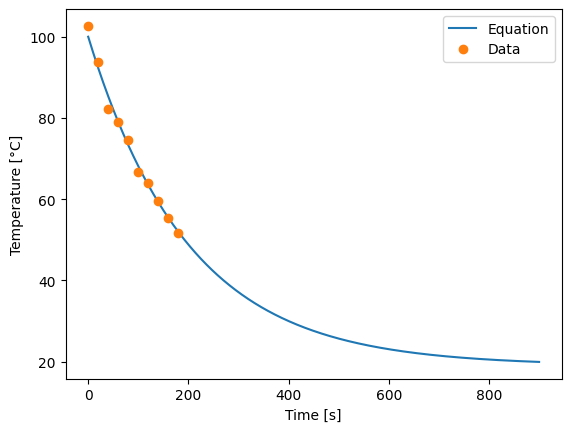

In [8]:
t_measured = np.linspace(0, int(t_cool/4)*60, 10)
T_measured = physics_law(t_measured, T_room, T_coffee, cooling_rate) + 2 * np.random.randn(10)

evolution = plot_evolution(t, T, t_measured, T_measured)

---


## **3. PINN model and physics loss**

In [9]:
class create_PINN_model(keras.Model):
    def __init__(self,
                 input_dim,
                 output_dim,
                 n_units=100,
                 epochs=1000,
                 loss=keras.losses.MeanSquaredError(),
                 lr=1e-3,
                 loss2=None,
                 loss2_weight=0.1):
        super(create_PINN_model, self).__init__()

        self.epochs = epochs
        self.loss = loss
        self.loss2 = loss2
        self.loss2_weight = loss2_weight
        self.lr = lr
        self.n_units = n_units

        self.layers_ = keras.Sequential([
            keras.layers.Dense(input_dim, activation='sigmoid'),
            keras.layers.Dense(self.n_units, activation='sigmoid'),
            keras.layers.Dense(self.n_units, activation='sigmoid'),
            keras.layers.Dense(self.n_units, activation='sigmoid'),
            keras.layers.Dense(output_dim)
        ])

    def call(self, x):
        return self.layers_(x)

    def fit(self, X, y):
        Xt = np_to_tf(X)
        yt = np_to_tf(y)

        optimizer = optimizers.Adam(learning_rate=self.lr)
        losses = []

        for epoch in range(self.epochs):
            with tf.GradientTape() as tape:
                outputs = self(Xt, training=True)
                loss = self.loss(yt, outputs)
                if self.loss2:
                    loss += self.loss2_weight * self.loss2(self)

            gradients = tape.gradient(loss, self.trainable_variables)
            optimizer.apply_gradients(zip(gradients, self.trainable_variables))
            losses.append(loss.numpy())

            if epoch % int(self.epochs/10) == 0:
                print(f"Epoch {epoch}/{self.epochs}, loss: {losses[-1]:.2f}")

        return losses

    def predict(self, X):
        Xt = np_to_tf(X)
        return self(Xt, training=False).numpy()


In [10]:
def physics_loss(model):
    ts = tf.linspace(0.0, t_cool*60, t_cool*60)[:, tf.newaxis]
    ts = tf.Variable(ts, trainable=True) # 'ts' becomes differentiable

    with tf.GradientTape() as tape:
        tape.watch(ts)
        T = model(ts)

    dT = tape.gradient(T, ts) # get gradient of T according to ts

    pde = cooling_rate * (T_room - T) - dT # partial differential equation

    # Retourne la moyenne du carré de l'erreur
    return tf.reduce_mean(pde**2)

---


## **4. Training and evaluation phase**

In [ ]:
PINN_model = create_PINN_model(1,1, loss2 = physics_loss, epochs=10000, loss2_weight=1, lr=1e-5)

PINN_model.compile(loss=keras.losses.MeanSquaredError(),
                   optimizer=keras.optimizers.Adam(learning_rate=1e-5),
                   metrics=None)

history = PINN_model.fit(t, T)

plt.plot(history)
plt.yscale('log')

Epoch 0/10000, loss: 1789.26
Epoch 1000/10000, loss: 1629.61
Epoch 2000/10000, loss: 1487.92
Epoch 3000/10000, loss: 1384.98
Epoch 4000/10000, loss: 1314.21
Epoch 5000/10000, loss: 1262.13
Epoch 6000/10000, loss: 1218.73
Epoch 7000/10000, loss: 1178.97
Epoch 8000/10000, loss: 1141.50


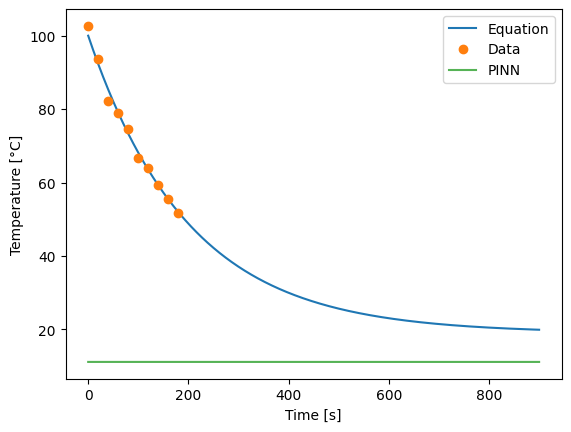

In [13]:
plot_predictions(PINN_model, t, T, t_measured, T_measured)

---


## **5. Inverse problem**

In [ ]:
class create_PINN_model_parameter(keras.Model):
    def __init__(self,
                input_dim,
                output_dim,
                n_units=100,
                epochs=1000,
                loss=keras.losses.MeanSquaredError(),
                lr=0.001,
                loss2=None,
                loss2_weight=0.1):
        super(create_PINN_model_parameter, self).__init__()

        self.epochs = epochs
        self.loss = loss
        self.loss2 = loss2
        self.loss2_weight = loss2_weight
        self.lr = lr
        self.n_units = n_units

        self.layers_ = keras.Sequential([
            keras.layers.Dense(input_dim, activation='sigmoid'),
            keras.layers.Dense(self.n_units, activation='sigmoid'),
            keras.layers.Dense(self.n_units, activation='sigmoid'),
            keras.layers.Dense(self.n_units, activation='sigmoid'),
            keras.layers.Dense(output_dim)
        ])

        self.r = tf.Variable(initial_value=0.0, trainable=True, dtype=tf.float32)

    def call(self, x):
        return self.layers_(x)

    def fit(self, X, y):
        Xt = np_to_tf(X)
        yt = np_to_tf(y)

        optimizer = optimizers.Adam(learning_rate=self.lr)
        losses = []

        for epoch in range(self.epochs):
            with tf.GradientTape() as tape:
                outputs = self(Xt, training=True)
                loss = self.loss(yt, outputs)
                if self.loss2:
                    loss += self.loss2_weight * self.loss2(self)

            gradients = tape.gradient(loss, self.trainable_variables)
            optimizer.apply_gradients(zip(gradients, self.trainable_variables))
            losses.append(loss.numpy())

            if epoch % int(self.epochs/10) == 0:
                print(f"Epoch {epoch}/{self.epochs}, loss: {losses[-1]:.2f}")

        return losses

    def predict(self, X):
        Xt = np_to_tf(X)
        return self(Xt, training=False).numpy()


In [ ]:
def physics_loss_parameter(model):
    # Crée un tenseur TensorFlow pour les valeurs de temps
    ts = tf.linspace(0.0, t_cool*60, t_cool*60)[:, tf.newaxis]

    # Rendre le tenseur 'ts' différentiable
    ts = tf.Variable(ts, trainable=True)

    # Utilise le modèle pour obtenir les prédictions
    with tf.GradientTape() as tape:
        tape.watch(ts)
        temps = model(ts)

    # Calcule le gradient de 'temps' par rapport à 'ts'
    dT = tape.gradient(temps, ts)

    # Calcule l'équation différentielle partielle (PDE)
    pde = model.r * (T_room - temps) - dT

    # Retourne la moyenne du carré de l'erreur
    return tf.reduce_mean(pde**2)

In [ ]:
PINN_model_parameter = create_PINN_model_parameter(1, 1, loss2=physics_loss_parameter, loss2_weight=1, epochs=1000, lr= 5e-6)

PINN_model_parameter.compile(loss=keras.losses.MeanSquaredError(),
                             optimizer=keras.optimizers.Adam(learning_rate=1e-5),
                             metrics=None)

history = PINN_model_parameter.fit(t, T)
plt.plot(history)
plt.yscale('log')

In [ ]:
plot_predictions(PINN_model_parameter, t, T, t_measured, T_measured)